# Signal implementation analysis: Sentiment polarity

## Setup

In [1]:
from pathlib import Path
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# plot settings
plt.style.use('seaborn-whitegrid')

# load datasets
likert_datasets = ["credcoalition.csv", "microsoft.csv", "reconcile.csv"]
binary_datasets = ["fnn-gossip.csv", "fnn-politifact.csv"]

likert_per_file = (pd.read_csv(os.path.join(os.getcwd(), "datasets_evaluated", dataset), sep=";",index_col="url") 
                   for dataset in likert_datasets)
binary_per_file = (pd.read_csv(os.path.join(os.getcwd(), "datasets_evaluated", dataset), sep=";",index_col="url") 
                   for dataset in binary_datasets)

likert_df = pd.concat(likert_per_file)
binary_df = pd.concat(binary_per_file)

# group likert ratings into bins
likert_df["rating_bin"] = likert_df.apply(lambda row: 1 if row.rating < 1.5 else 2 if row.rating < 2.5
                                          else 3 if row.rating < 3.5 else 4 if row.rating < 4.5 else 5, axis=1)

# swap 0 <-> 1 fake news classification to facilitate comparisons with credibility ratings (higher rating = better)
binary_df["rating"] = 1 - binary_df["rating"]

# rating distributions
print("\nLikert data: " + str(likert_df.shape) + " urls x values\nRating bins distribution:")
print(likert_df["rating_bin"].value_counts().sort_index().to_string())
print("\nBinary data: " + str(binary_df.shape) + " urls x values\nRatings distribution:")
print(binary_df["rating"].value_counts().sort_index().to_string())


Likert data: (242, 84) urls x values
Rating bins distribution:
1     16
2     24
3     36
4    109
5     57

Binary data: (200, 83) urls x values
Ratings distribution:
0.0    100
1.0    100


## Text sentiment spaCy

In [2]:
signal = "sentiment_text_spacy"

#### Scatterplots

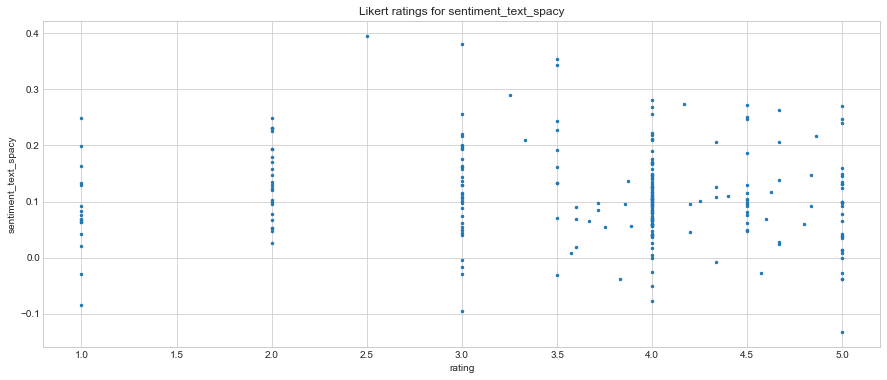

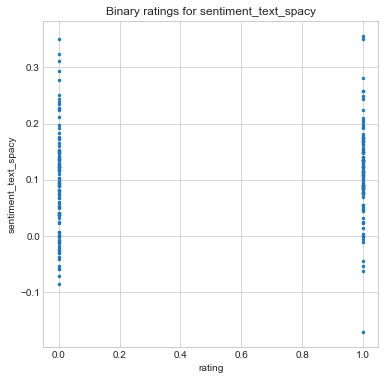

In [3]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

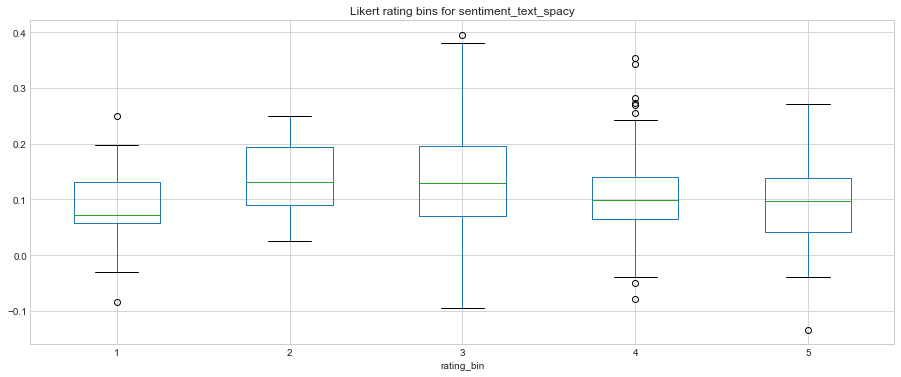

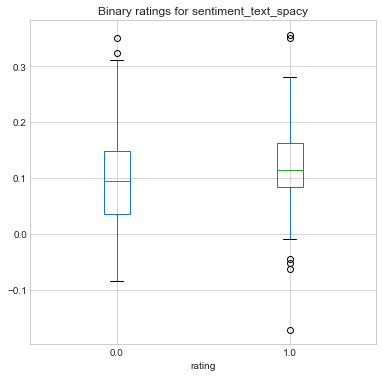

In [4]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

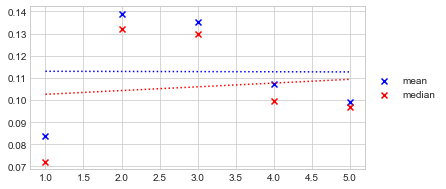

   rating      mean    median
0       1  0.083672  0.072057
1       2  0.139001  0.131850
2       3  0.135063  0.129768
3       4  0.107171  0.099336
4       5  0.099223  0.096770


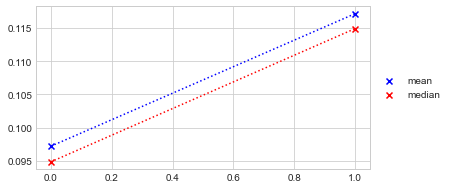

   rating      mean    median
0       0  0.097200  0.094851
1       1  0.117143  0.114896


In [5]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [6]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.11135762482326225
Likert p: 0.08385752064084387

Binary rho: 0.1328500073953892
Binary p: 0.06074768574225854


## Text sentiment VADER

In [7]:
signal = "sentiment_text_vader"

#### Scatterplots

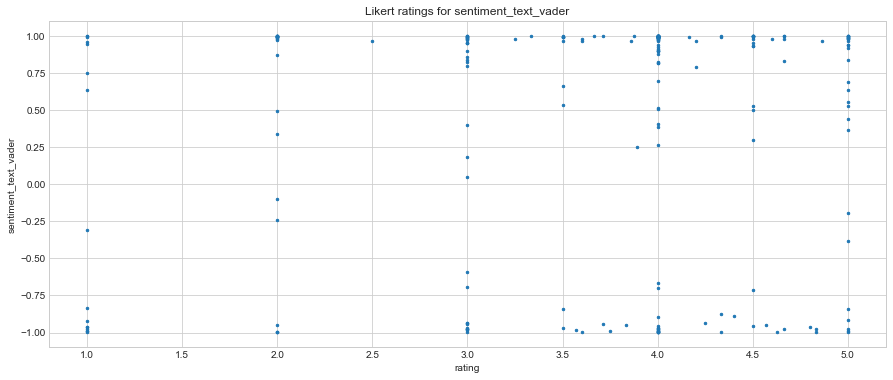

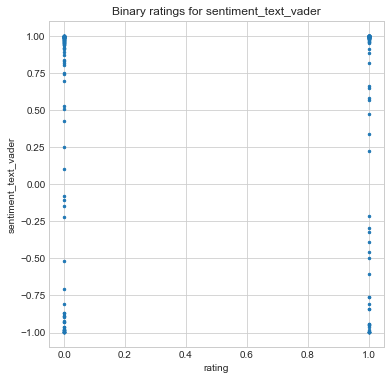

In [8]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

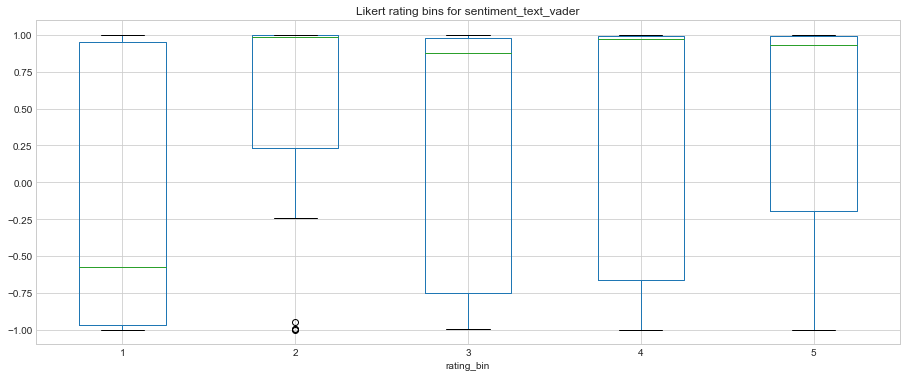

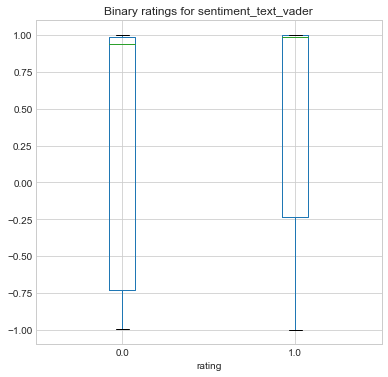

In [9]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

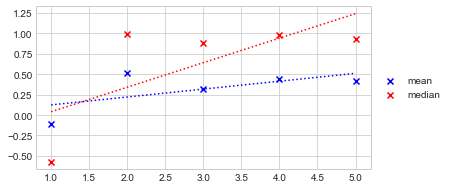

   rating      mean   median
0       1 -0.104012 -0.57310
1       2  0.513400  0.98895
2       3  0.320614  0.87780
3       4  0.438353  0.97260
4       5  0.416644  0.93460


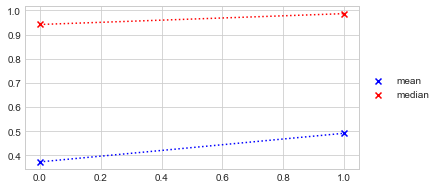

   rating      mean   median
0       0  0.372767  0.94165
1       1  0.491288  0.98660


In [10]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [11]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: 0.03516468542079026
Likert p: 0.5861867490454528

Binary rho: 0.22804119344569204
Binary p: 0.0011635249649973685


## Text positivity spaCy

In [12]:
likert_df["positivity_text_spacy"] = np.maximum(likert_df["sentiment_text_spacy"], 0)
binary_df["positivity_text_spacy"] = np.maximum(binary_df["sentiment_text_spacy"], 0)

signal = "positivity_text_spacy"

#### Scatterplots

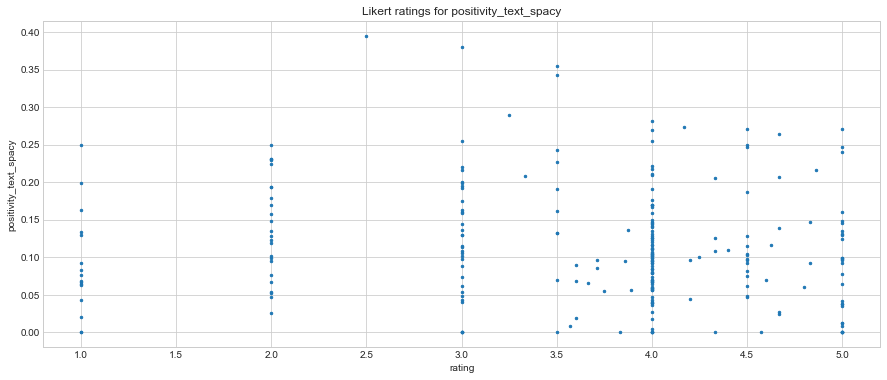

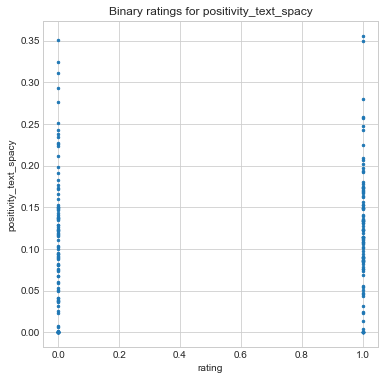

In [13]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

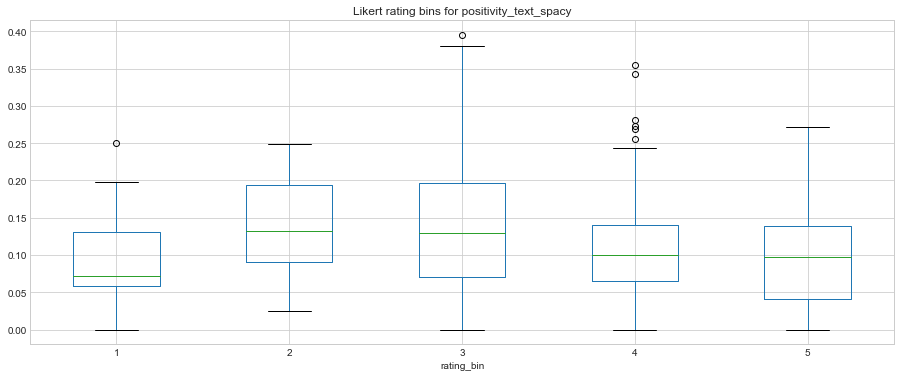

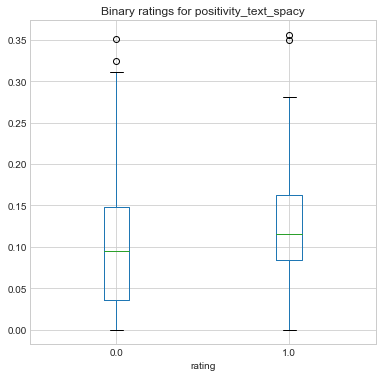

In [14]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

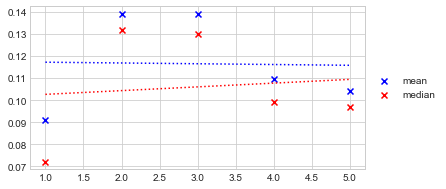

   rating      mean    median
0       1  0.090787  0.072057
1       2  0.139001  0.131850
2       3  0.139052  0.129768
3       4  0.109295  0.099336
4       5  0.103896  0.096770


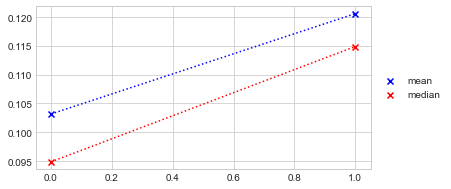

   rating      mean    median
0       0  0.103164  0.094851
1       1  0.120608  0.114896


In [15]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [16]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.1121043097622251
Likert p: 0.08178976949884337

Binary rho: 0.13360286286063947
Binary p: 0.05928809270530316


## Text positivity VADER

In [17]:
signal = "positivity_text_vader"

#### Scatterplots

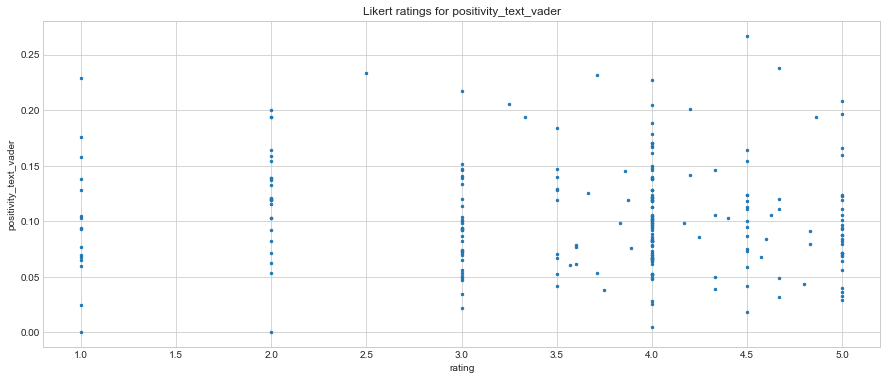

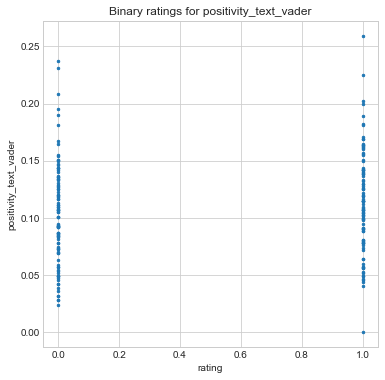

In [18]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

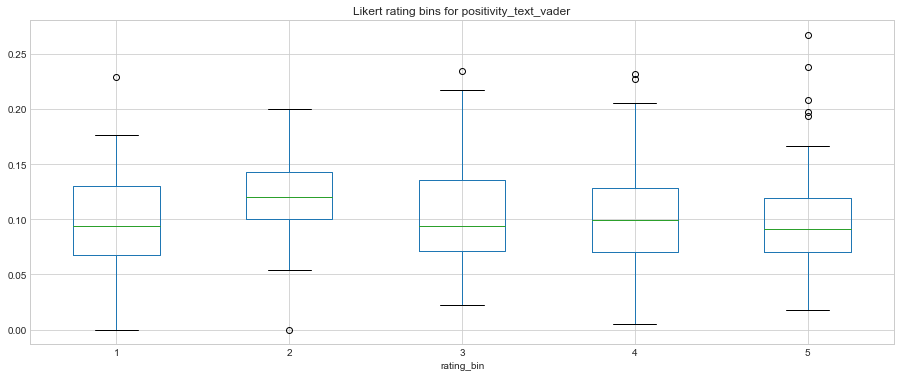

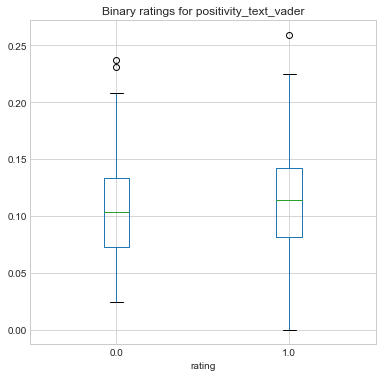

In [19]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

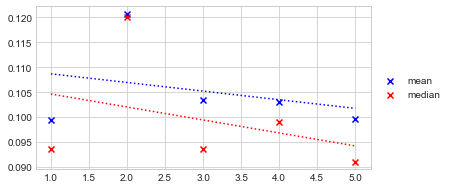

   rating      mean  median
0       1  0.099312  0.0935
1       2  0.120708  0.1200
2       3  0.103417  0.0935
3       4  0.102917  0.0990
4       5  0.099561  0.0910


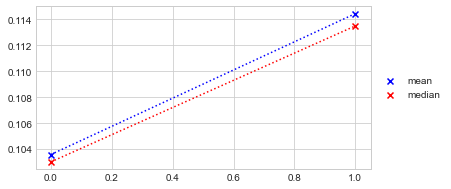

   rating     mean  median
0       0  0.10357  0.1030
1       1  0.11445  0.1135


In [20]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [21]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.08051604846343074
Likert p: 0.2120025193859981

Binary rho: 0.12714413170695893
Binary p: 0.07279604503370483


## Text sentiment FastText 5

In [22]:
signal = "sentiment_text_fasttext_5"

#### Scatterplots

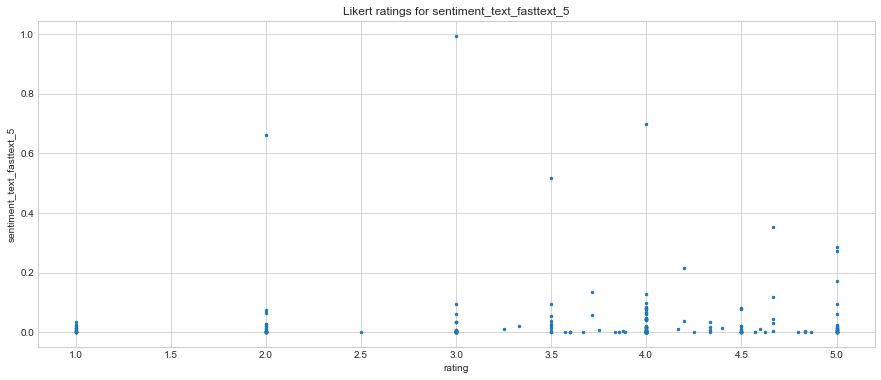

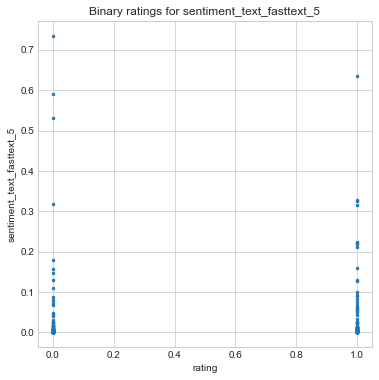

In [23]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

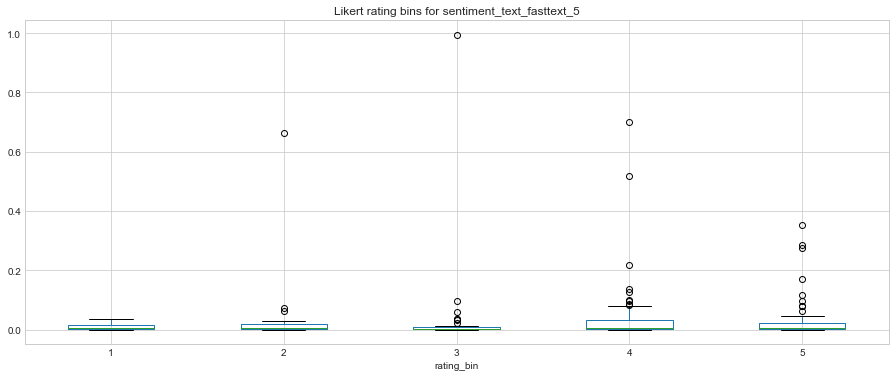

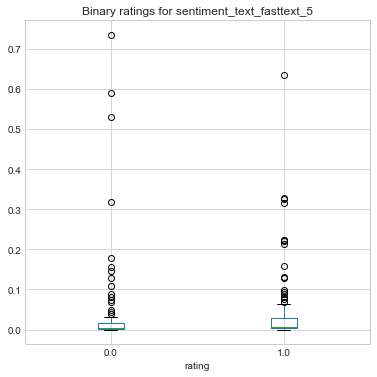

In [24]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

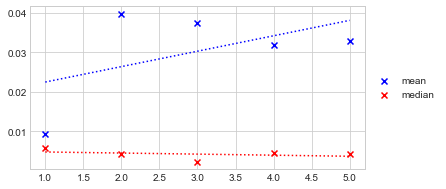

   rating      mean    median
0       1  0.009434  0.005835
1       2  0.039826  0.004266
2       3  0.037458  0.002277
3       4  0.031939  0.004464
4       5  0.032903  0.004381


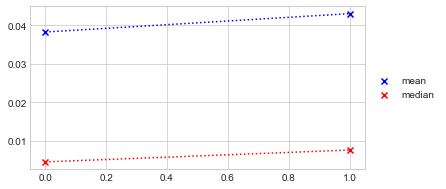

   rating      mean    median
0       0  0.038225  0.004486
1       1  0.043000  0.007565


In [25]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [26]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: 0.09917144585058603
Likert p: 0.12391345170167184

Binary rho: 0.15432765606214477
Binary p: 0.029114613259068688


## Text negativity spaCy

In [27]:
likert_df["negativity_text_spacy"] = np.minimum(likert_df["sentiment_text_spacy"], 0)
binary_df["negativity_text_spacy"] = np.minimum(binary_df["sentiment_text_spacy"], 0)

signal = "negativity_text_spacy"

#### Scatterplots

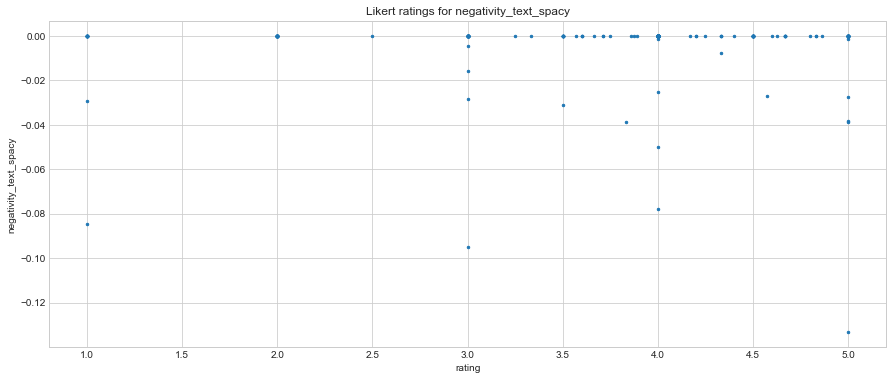

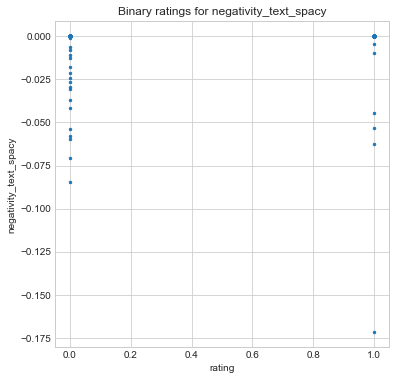

In [28]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

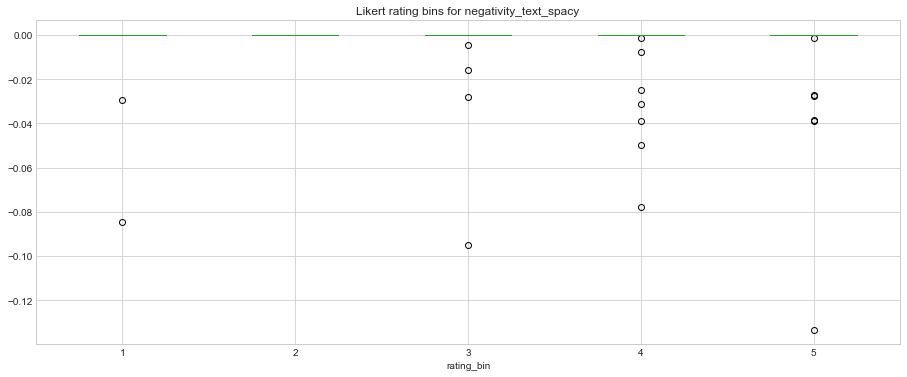

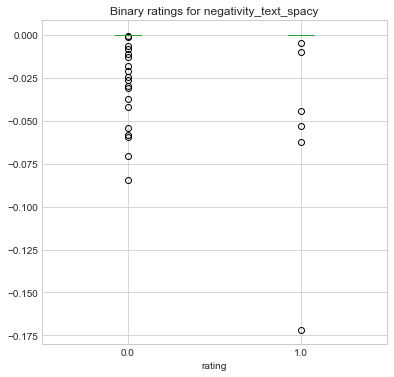

In [29]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

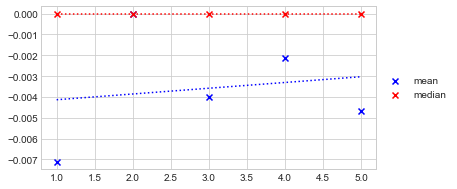

   rating      mean  median
0       1 -0.007115     0.0
1       2  0.000000     0.0
2       3 -0.003989     0.0
3       4 -0.002124     0.0
4       5 -0.004673     0.0


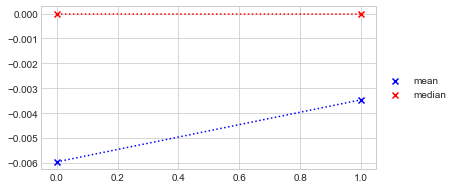

   rating      mean  median
0       0 -0.005964     0.0
1       1 -0.003466     0.0


In [30]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [31]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.041376824890974086
Likert p: 0.5217734553602454

Binary rho: 0.19204090490572515
Binary p: 0.006444789445226689


## Text negativity VADER

In [32]:
signal = "negativity_text_vader"

#### Scatterplots

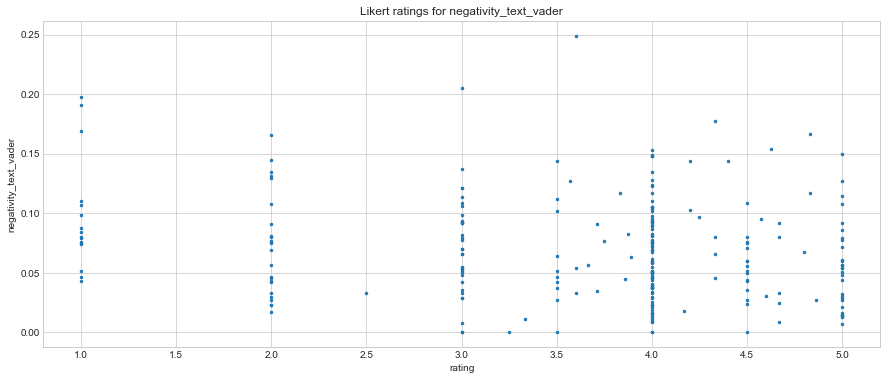

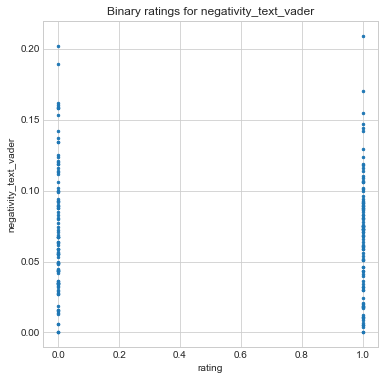

In [33]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

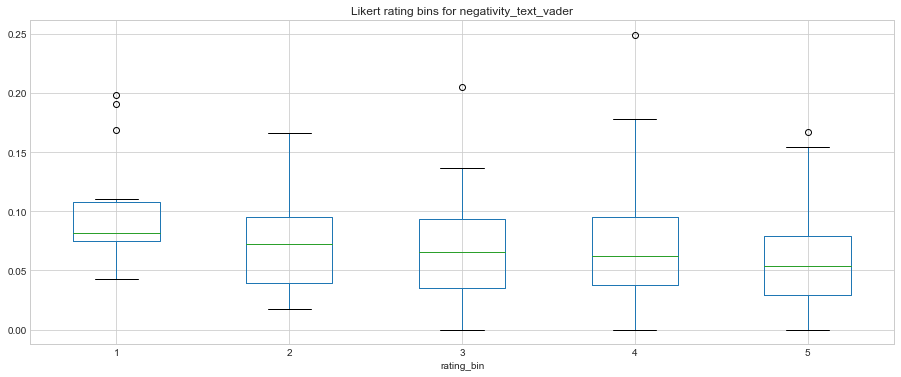

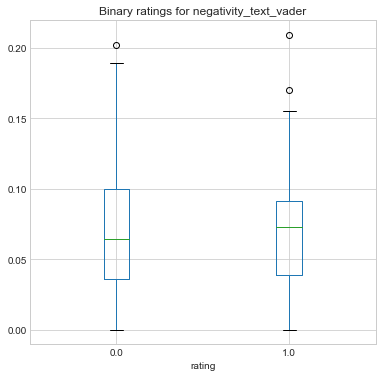

In [34]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

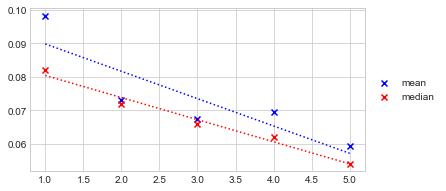

   rating      mean  median
0       1  0.098250   0.082
1       2  0.073000   0.072
2       3  0.067444   0.066
3       4  0.069495   0.062
4       5  0.059193   0.054


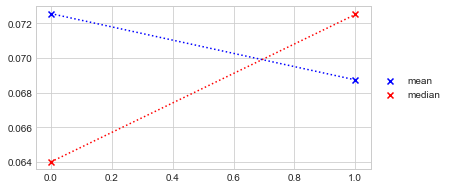

   rating     mean  median
0       0  0.07255  0.0640
1       1  0.06873  0.0725


In [35]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [36]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.1439855760451918
Likert p: 0.0250923913532441

Binary rho: -0.016022926119590036
Binary p: 0.8218295063962168


## Text sentiment FastText 1

In [37]:
signal = "sentiment_text_fasttext_1"

#### Scatterplots

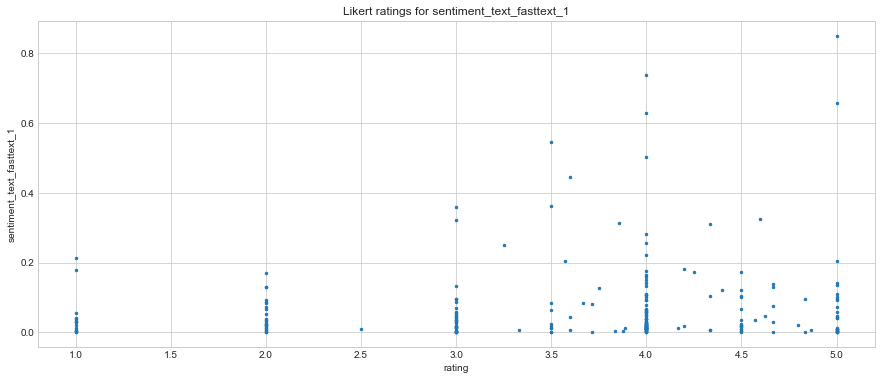

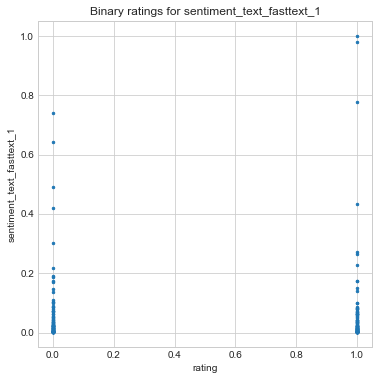

In [38]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

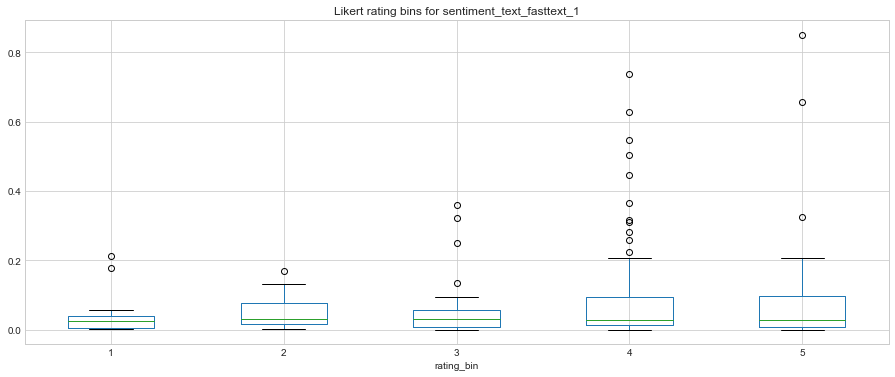

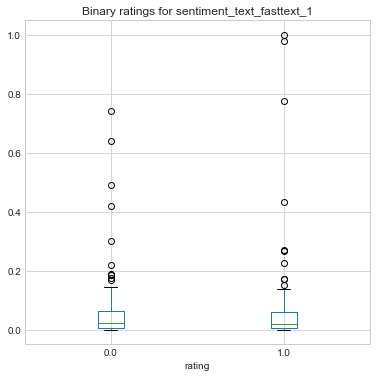

In [39]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

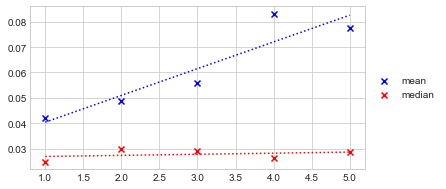

   rating      mean    median
0       1  0.042199  0.024816
1       2  0.048606  0.029868
2       3  0.056002  0.029272
3       4  0.083149  0.026401
4       5  0.077530  0.028697


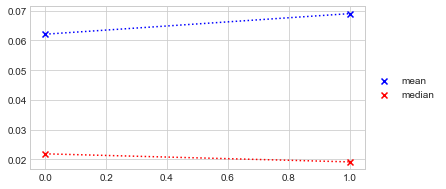

   rating      mean    median
0       0  0.062105  0.021890
1       1  0.069014  0.019182


In [40]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [41]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: 0.045479172397388835
Likert p: 0.48131367785250034

Binary rho: -0.026327501370870934
Binary p: 0.7113396545906513


## Text sentiment absolute spaCy

In [42]:
# extract absolute sentiment values
likert_df["sentiment_text_abs_spacy"] = likert_df["sentiment_text_spacy"].abs()
binary_df["sentiment_text_abs_spacy"] = binary_df["sentiment_text_spacy"].abs()

signal = "sentiment_text_abs_spacy"

#### Scatterplots

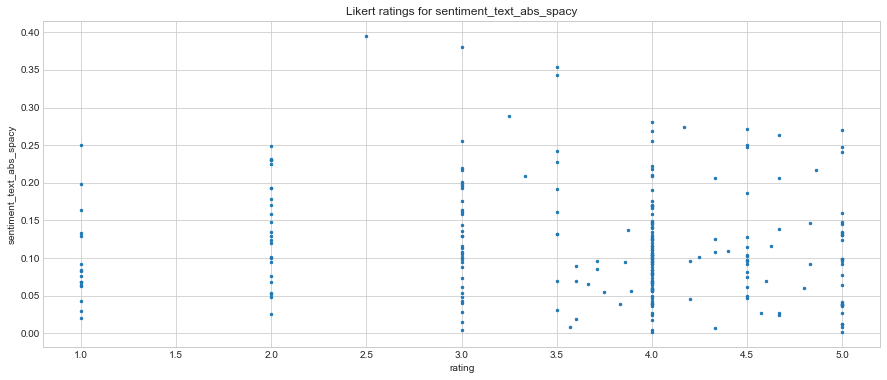

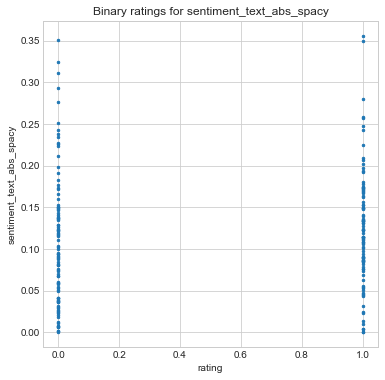

In [43]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

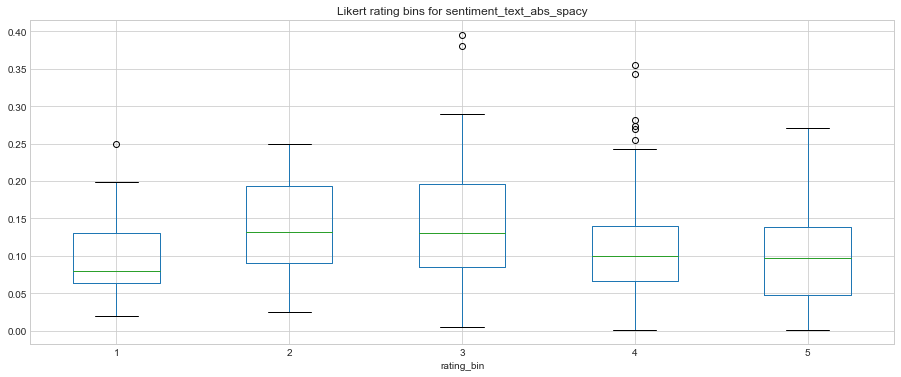

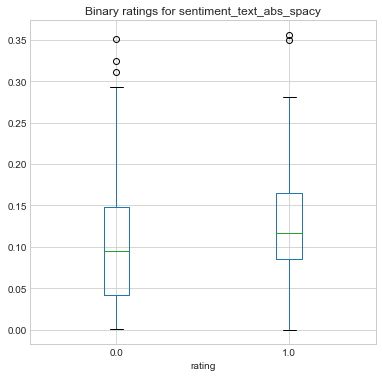

In [44]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

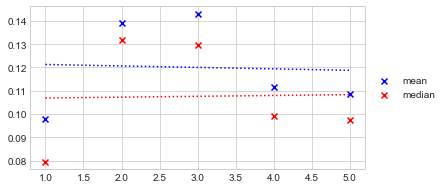

   rating      mean    median
0       1  0.097902  0.079475
1       2  0.139001  0.131850
2       3  0.143041  0.129768
3       4  0.111419  0.099336
4       5  0.108569  0.097524


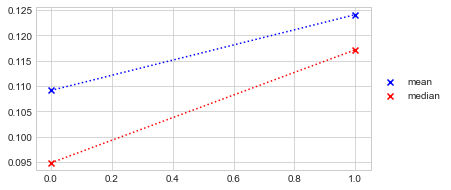

   rating      mean    median
0       0  0.109128  0.094851
1       1  0.124074  0.117145


In [45]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [46]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.11243922811787381
Likert p: 0.08087574936969538

Binary rho: 0.1335428366386507
Binary p: 0.05940339852087937


## Text sentiment absolute VADER

In [47]:
# extract absolute sentiment values
likert_df["sentiment_text_abs_vader"] = likert_df["sentiment_text_vader"].abs()
binary_df["sentiment_text_abs_vader"] = binary_df["sentiment_text_vader"].abs()

signal = "sentiment_text_abs_vader"

#### Scatterplots

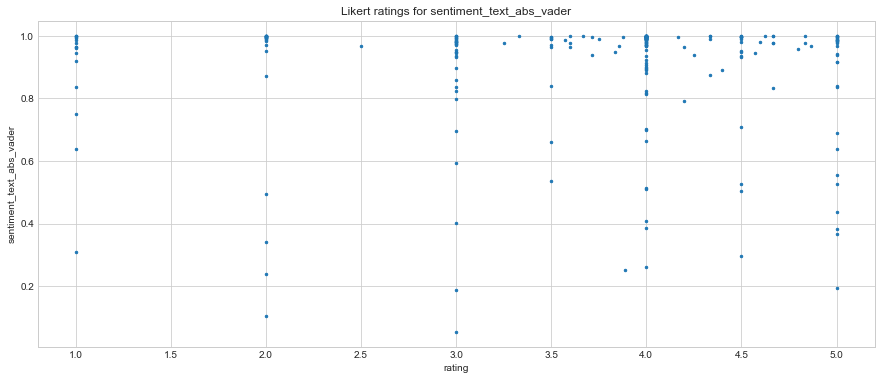

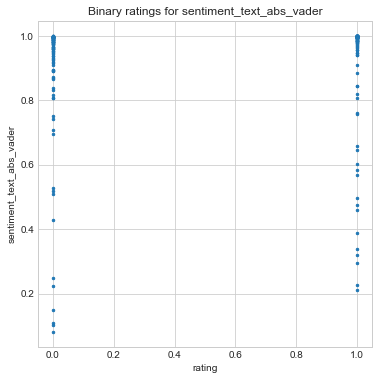

In [48]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

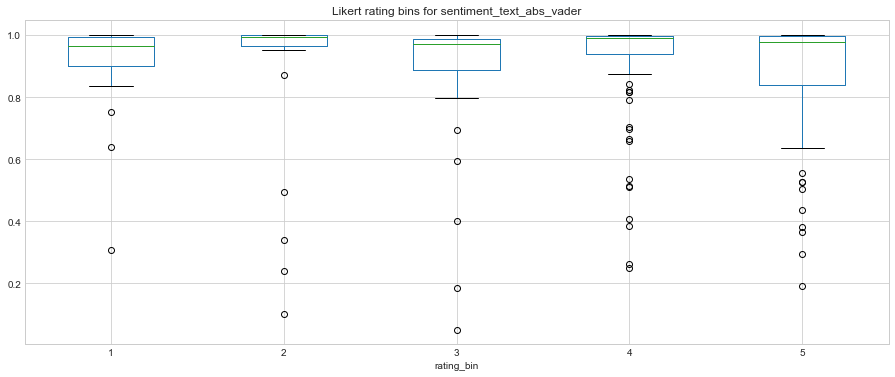

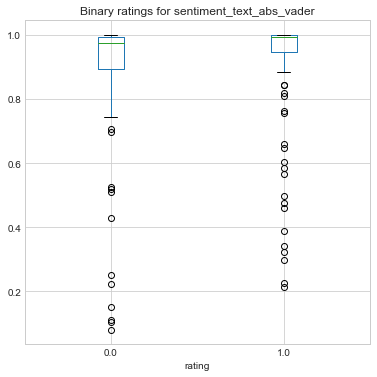

In [49]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

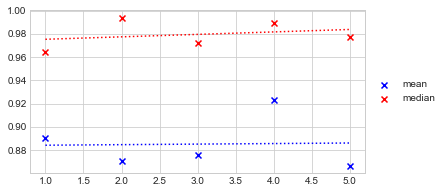

   rating      mean  median
0       1  0.890375  0.9646
1       2  0.870542  0.9940
2       3  0.875542  0.9726
3       4  0.923102  0.9893
4       5  0.866472  0.9775


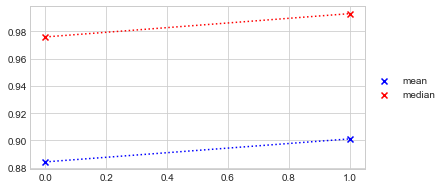

   rating      mean  median
0       0  0.884291  0.9760
1       1  0.901176  0.9931


In [50]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [51]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.025088759748531836
Likert p: 0.6977719284131871

Binary rho: 0.25142908143169507
Binary p: 0.00032900465345895284


## Text sentiment FastText 1+5

In [52]:
# extract absolute sentiment values
likert_df["sentiment_text_fasttext1+5"] = likert_df["sentiment_text_fasttext_1"] + likert_df["sentiment_text_fasttext_5"]
binary_df["sentiment_text_fasttext1+5"] = binary_df["sentiment_text_fasttext_1"] + binary_df["sentiment_text_fasttext_5"]

signal = "sentiment_text_fasttext1+5"

#### Scatterplots

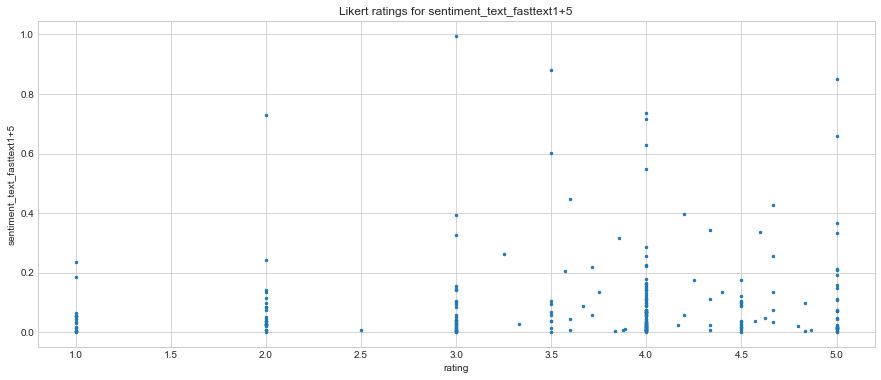

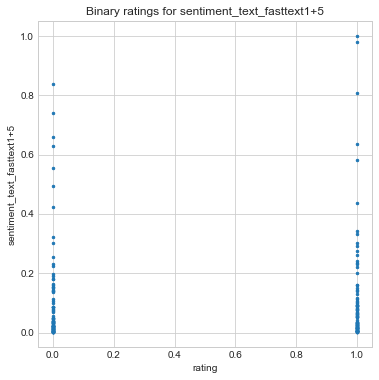

In [53]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

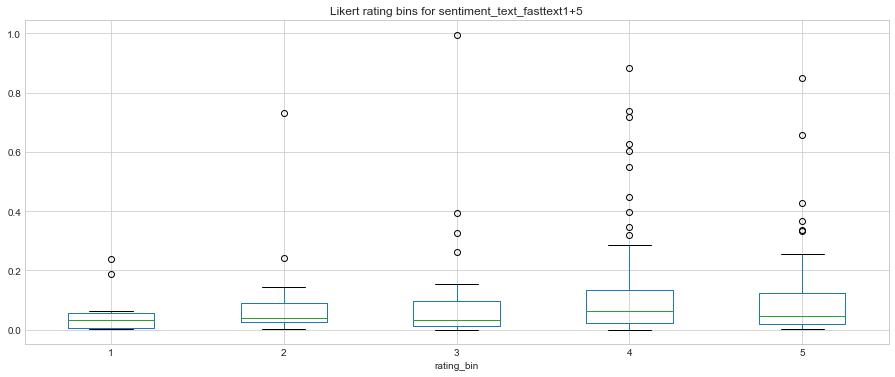

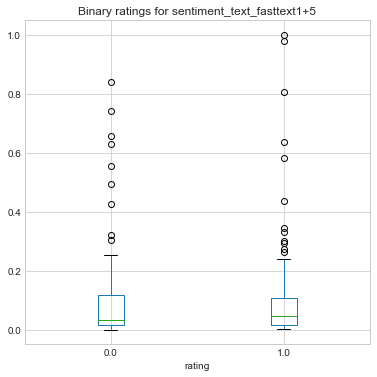

In [54]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

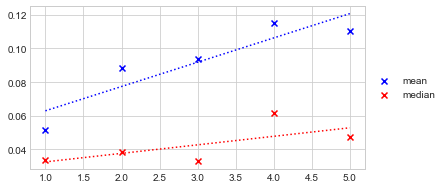

   rating      mean    median
0       1  0.051632  0.033519
1       2  0.088431  0.038477
2       3  0.093460  0.032878
3       4  0.115088  0.061506
4       5  0.110433  0.047318


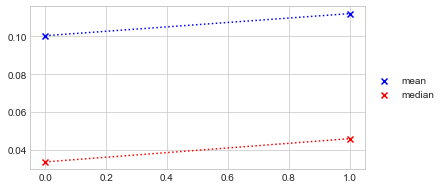

   rating      mean    median
0       0  0.100330  0.033456
1       1  0.112015  0.045759


In [55]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [56]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: 0.10458464572601416
Likert p: 0.10459253801600052

Binary rho: 0.05161575926657591
Binary p: 0.467921110129883


## Clean data for headline signals

In [57]:
# get dataframes without rows containing missing data (-10 => signal could not be evaluated)
signal = "sentiment_title_spacy"
likert_copy = likert_df
binary_copy = binary_df
likert_df = likert_df[likert_df[signal] > -10]
binary_df = binary_df[binary_df[signal] > -10]

## Headline sentiment spaCy

In [58]:
signal = "sentiment_title_spacy"

#### Scatterplots

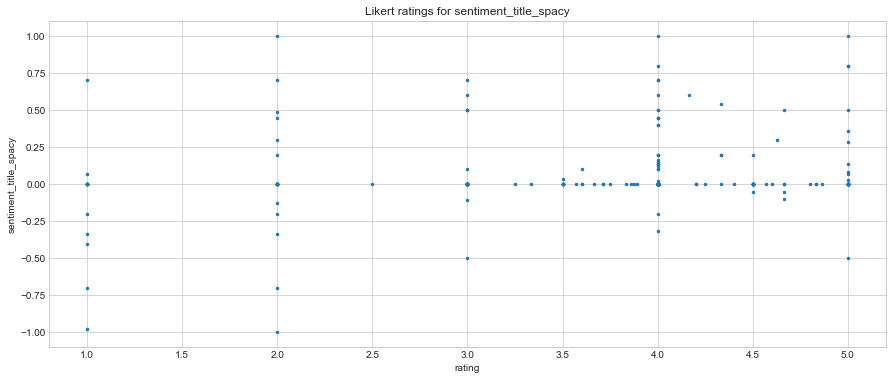

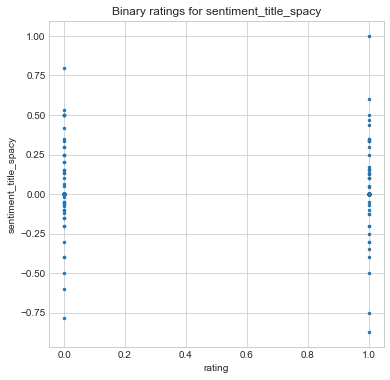

In [59]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

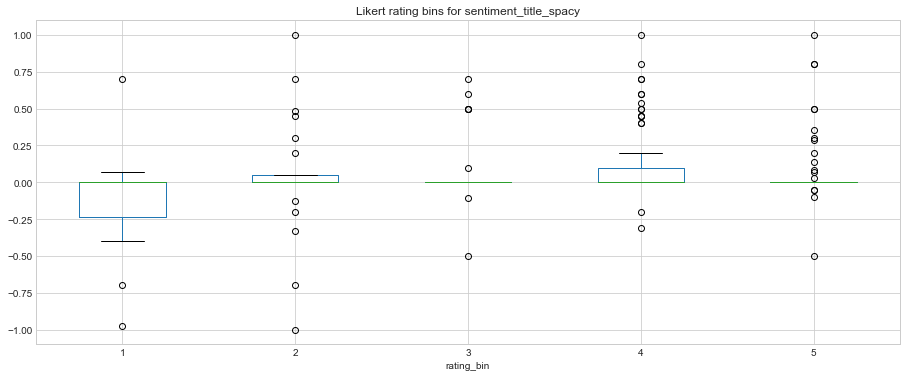

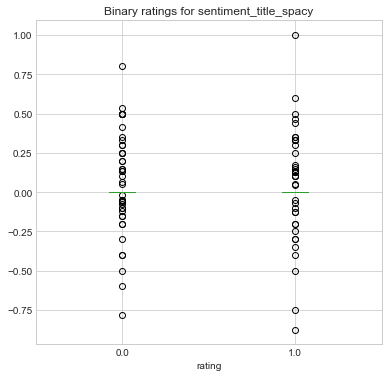

In [60]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

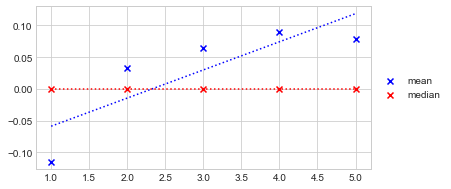

   rating      mean  median
0       1 -0.115104     0.0
1       2  0.032465     0.0
2       3  0.063715     0.0
3       4  0.089801     0.0
4       5  0.077831     0.0


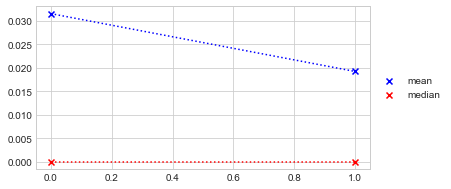

   rating      mean  median
0       0  0.031570     0.0
1       1  0.019253     0.0


In [61]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [62]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: 0.15794530534310994
Likert p: 0.014102201329880779

Binary rho: 0.006921149750508216
Binary p: 0.9225139752459443


## Headline sentiment VADER

In [63]:
signal = "sentiment_title_vader"

#### Scatterplots

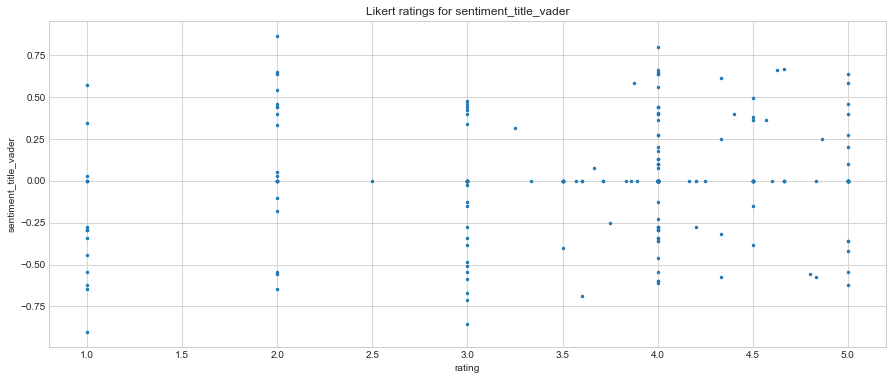

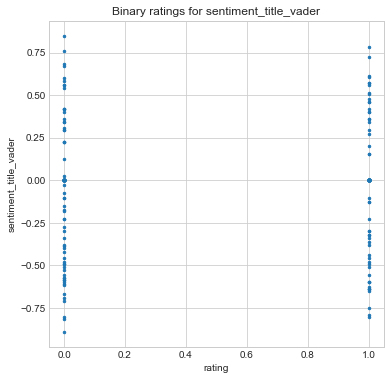

In [64]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

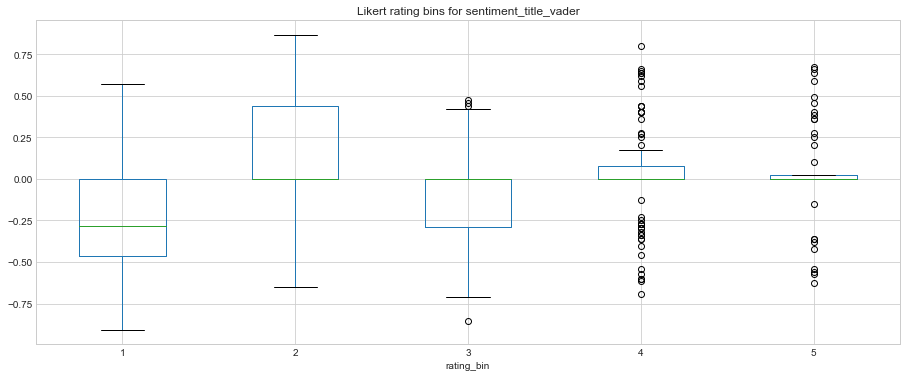

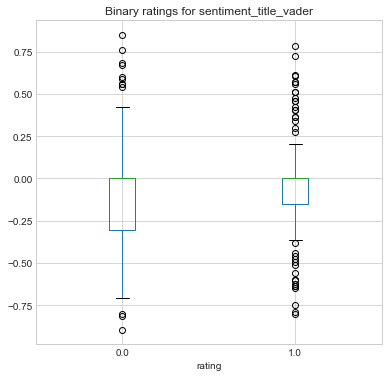

In [65]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

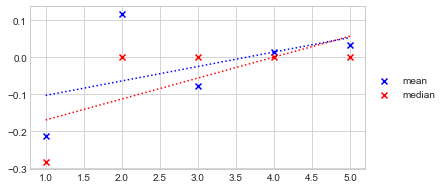

   rating      mean  median
0       1 -0.213594 -0.2829
1       2  0.117375  0.0000
2       3 -0.077881  0.0000
3       4  0.014192  0.0000
4       5  0.033298  0.0000


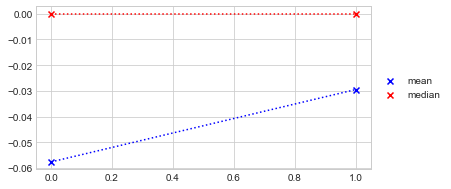

   rating      mean  median
0       0 -0.057617     0.0
1       1 -0.029520     0.0


In [66]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [67]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: 0.0949783514271581
Likert p: 0.14152926966002496

Binary rho: 0.04625392297217161
Binary p: 0.5154485031795741


## Headline positivity spaCy

In [68]:
likert_df["positivity_title_spacy"] = np.maximum(likert_df["sentiment_title_spacy"], 0)
binary_df["positivity_title_spacy"] = np.maximum(binary_df["sentiment_title_spacy"], 0)

signal = "positivity_title_spacy"

#### Scatterplots

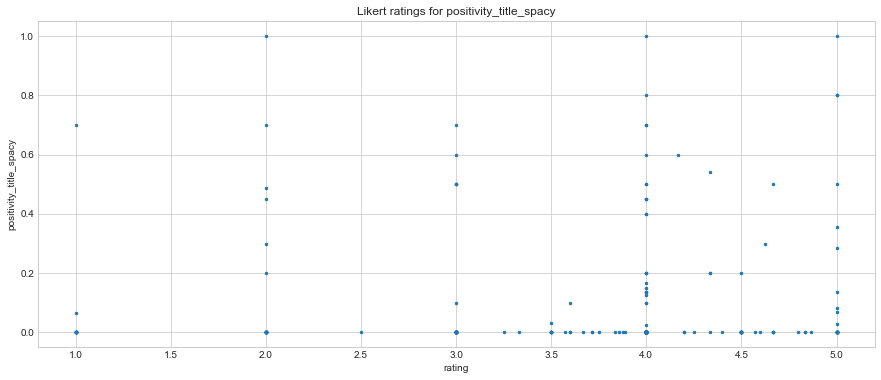

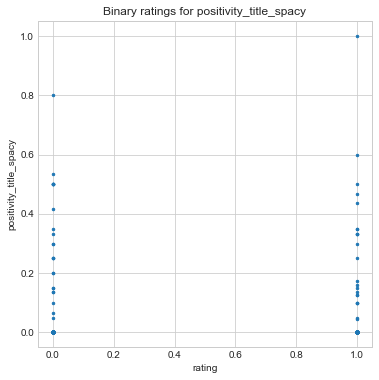

In [69]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

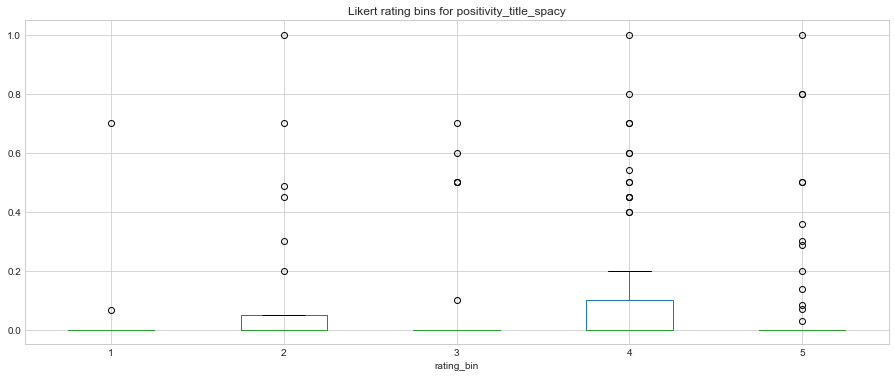

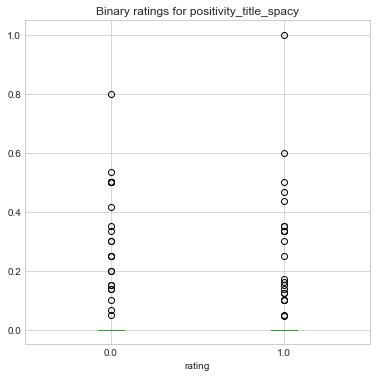

In [70]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

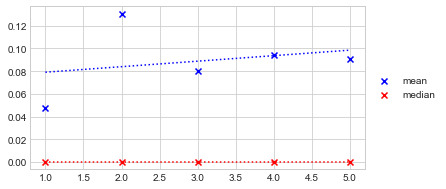

   rating      mean  median
0       1  0.047917     0.0
1       2  0.130729     0.0
2       3  0.080556     0.0
3       4  0.094502     0.0
4       5  0.090331     0.0


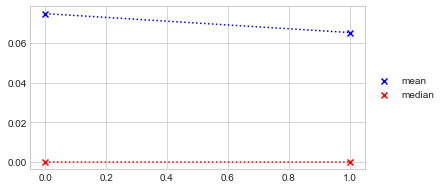

   rating      mean  median
0       0  0.074729     0.0
1       1  0.065197     0.0


In [71]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [72]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: 0.09419955700458287
Likert p: 0.14483743493555476

Binary rho: -0.020976869729490887
Binary p: 0.7681231986112278


## Headline positivity VADER

In [73]:
signal = "positivity_title_vader"

#### Scatterplots

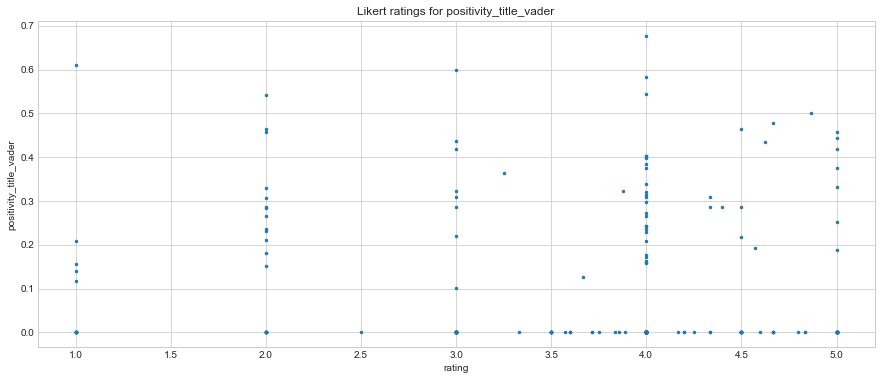

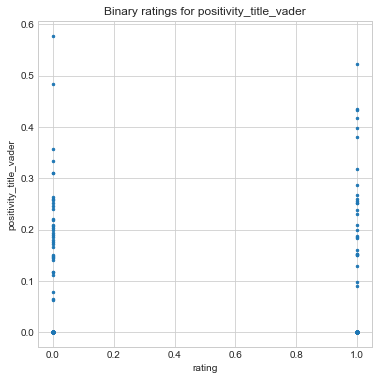

In [74]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

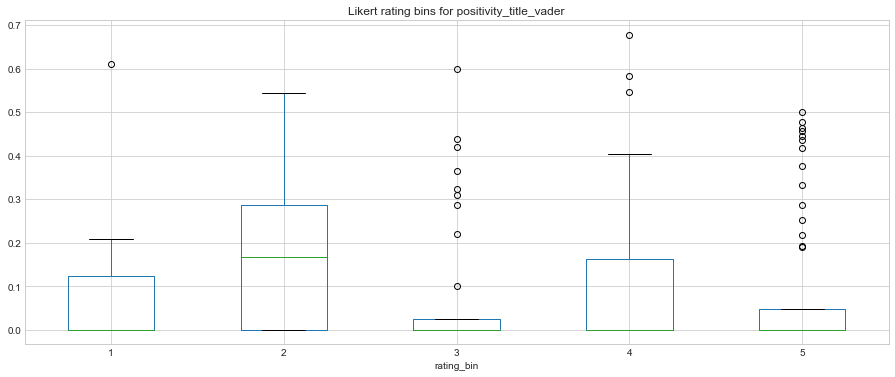

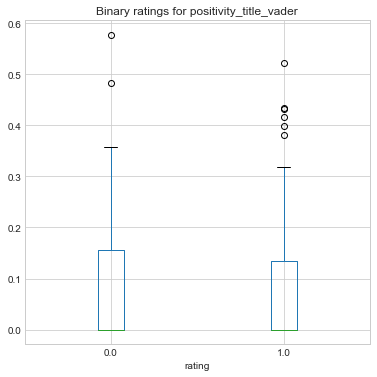

In [75]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

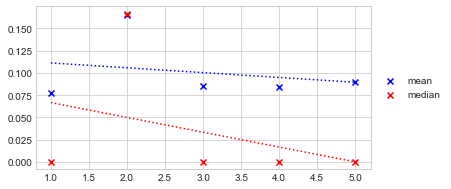

   rating      mean  median
0       1  0.077125  0.0000
1       2  0.164583  0.1665
2       3  0.085083  0.0000
3       4  0.084505  0.0000
4       5  0.090000  0.0000


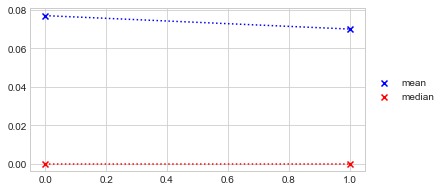

   rating     mean  median
0       0  0.07699     0.0
1       1  0.07002     0.0


In [76]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [77]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.038018848125593044
Likert p: 0.5569652744049629

Binary rho: -0.062234067734980074
Binary p: 0.38132640818225616


## Headline sentiment FastText 5

In [78]:
signal = "sentiment_title_fasttext_5"

#### Scatterplots

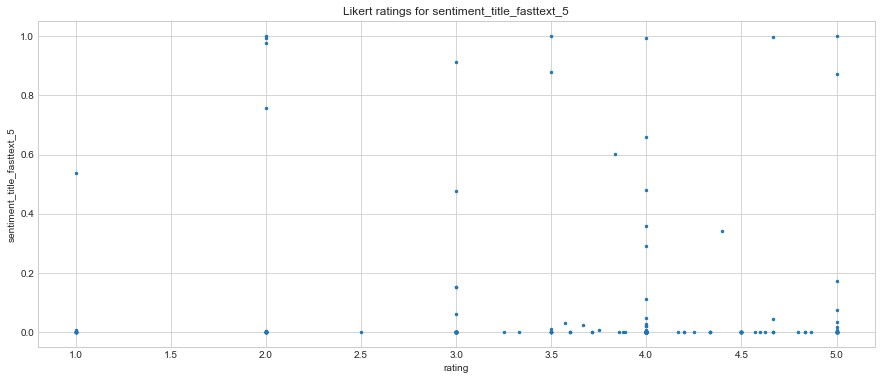

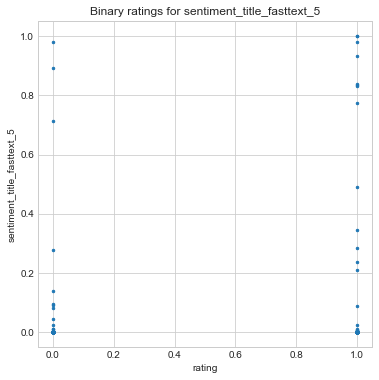

In [79]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

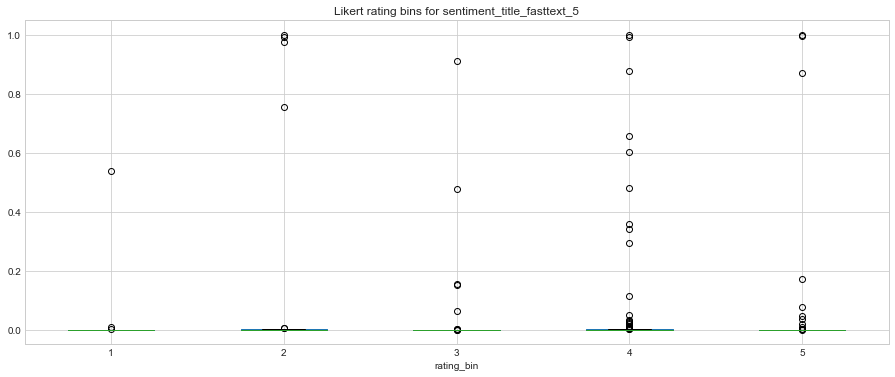

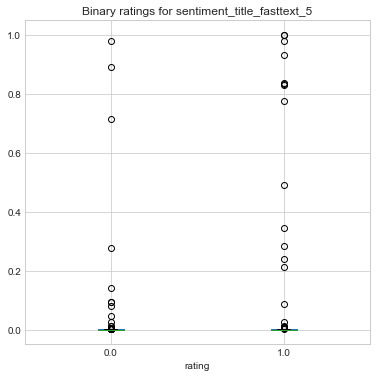

In [80]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

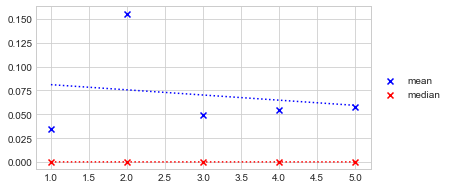

   rating      mean    median
0       1  0.034251  0.000019
1       2  0.155584  0.000010
2       3  0.048929  0.000010
3       4  0.054614  0.000011
4       5  0.057573  0.000010


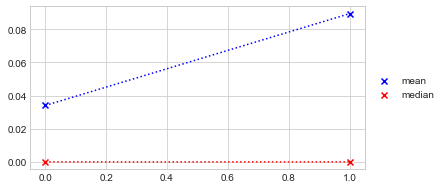

   rating      mean    median
0       0  0.034018  0.000011
1       1  0.089363  0.000014


In [81]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [82]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.03898536442850939
Likert p: 0.5469757688661827

Binary rho: 0.049345254576391856
Binary p: 0.4877474244382619


## Headline negativity spaCy

In [83]:
likert_df["negativity_title_spacy"] = np.minimum(likert_df["sentiment_title_spacy"], 0)
binary_df["negativity_title_spacy"] = np.minimum(binary_df["sentiment_title_spacy"], 0)

signal = "negativity_title_spacy"

#### Scatterplots

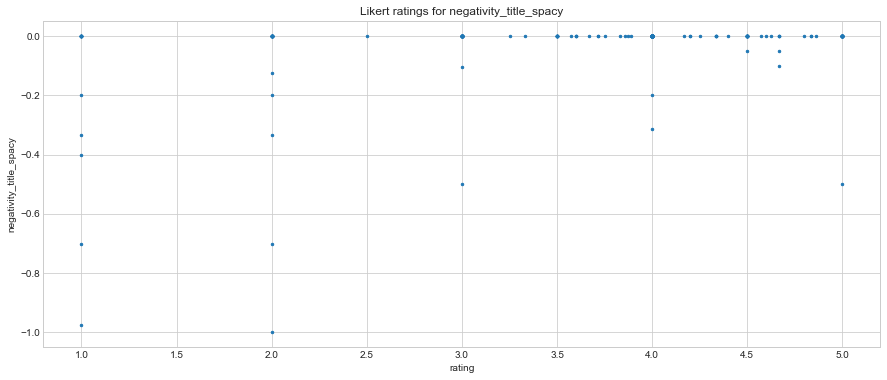

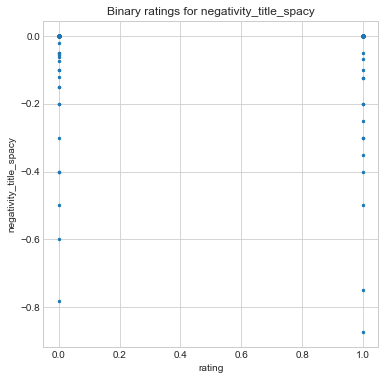

In [84]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

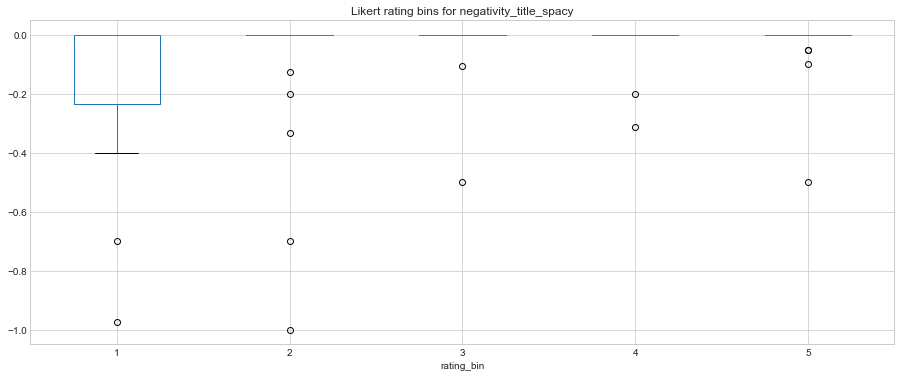

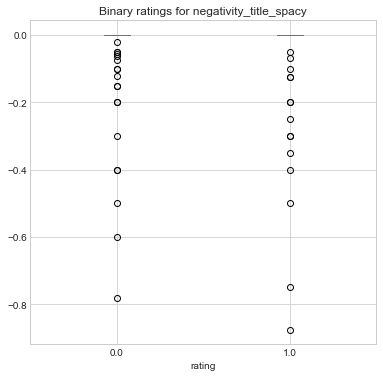

In [85]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

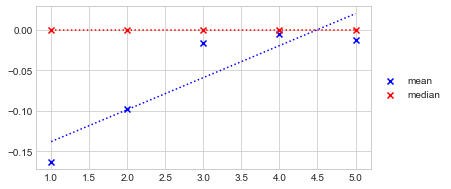

   rating      mean  median
0       1 -0.163021     0.0
1       2 -0.098264     0.0
2       3 -0.016840     0.0
3       4 -0.004702     0.0
4       5 -0.012500     0.0


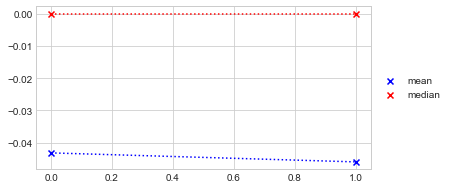

   rating      mean  median
0       0 -0.043160     0.0
1       1 -0.045944     0.0


In [86]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [87]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: 0.18463971673391266
Likert p: 0.0040243394652894945

Binary rho: 0.04340979516253791
Binary p: 0.5416319571667119


## Headline negativity VADER

In [88]:
signal = "negativity_title_vader"

#### Scatterplots

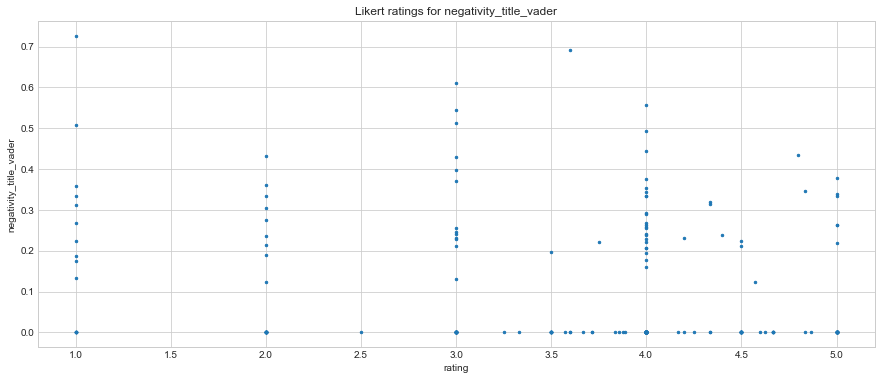

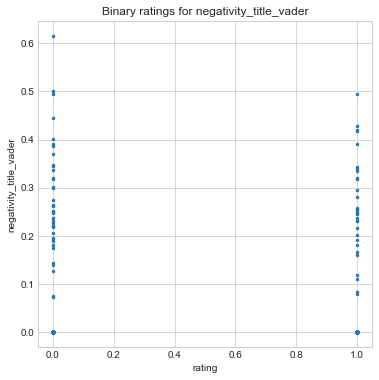

In [89]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

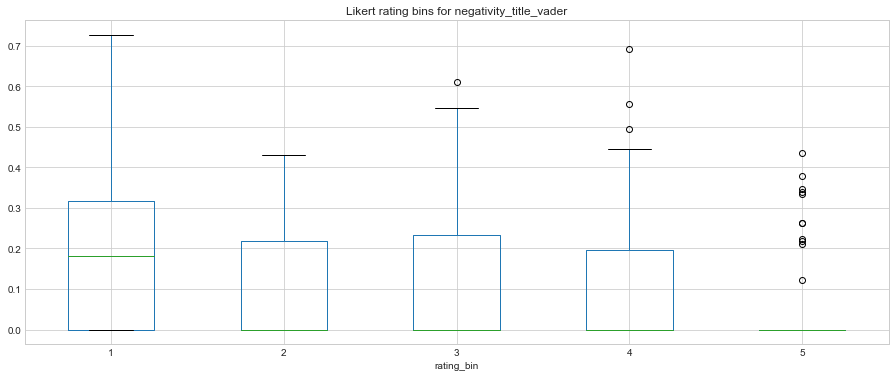

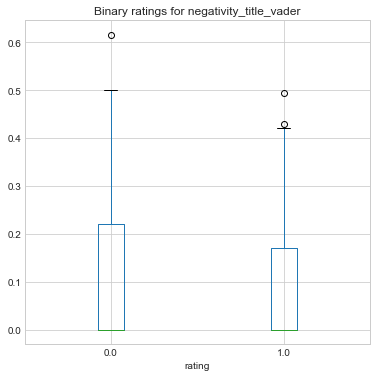

In [90]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

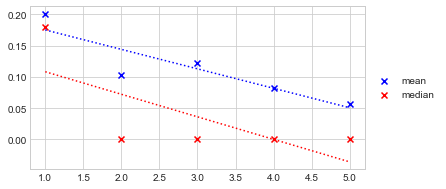

   rating      mean  median
0       1  0.201375  0.1805
1       2  0.102875  0.0000
2       3  0.122472  0.0000
3       4  0.082119  0.0000
4       5  0.055929  0.0000


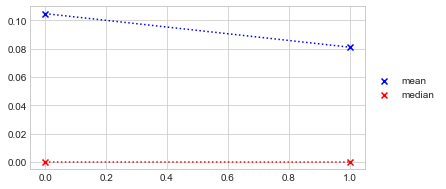

   rating     mean  median
0       0  0.10479     0.0
1       1  0.08108     0.0


In [91]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [92]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.15641030096499148
Likert p: 0.01507824373446054

Binary rho: -0.07649901737068447
Binary p: 0.28163359414917805


## Headline sentiment FastText 1

In [93]:
signal = "sentiment_title_fasttext_1"

#### Scatterplots

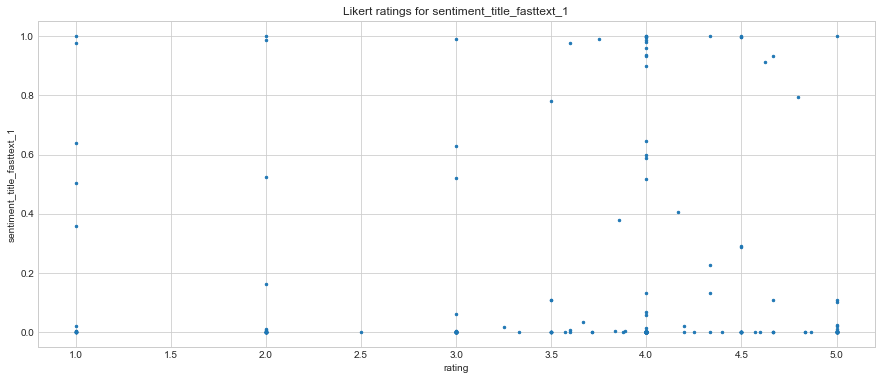

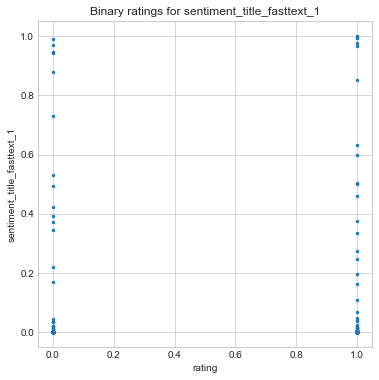

In [94]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

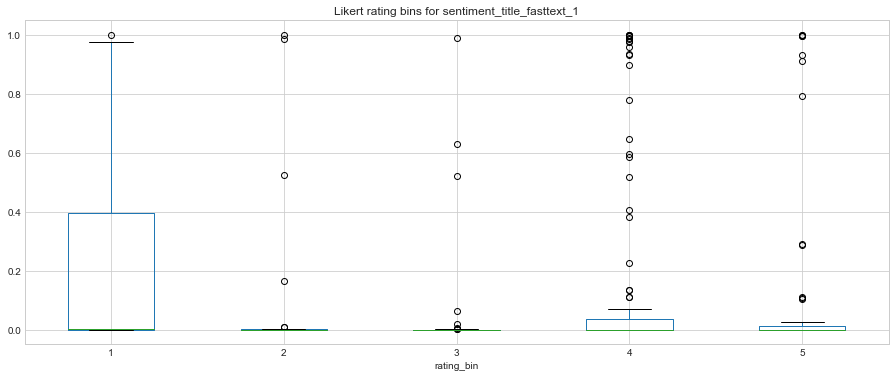

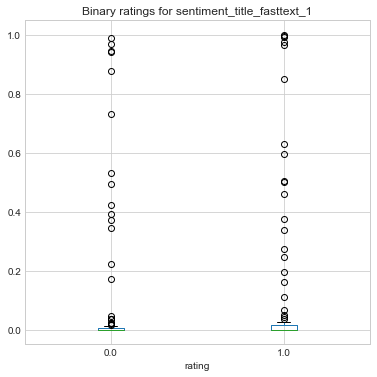

In [95]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

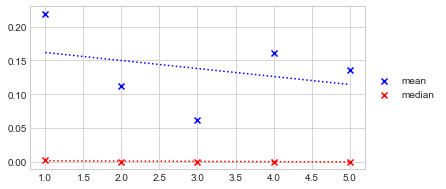

   rating      mean    median
0       1  0.219470  0.002060
1       2  0.112347  0.000013
2       3  0.061987  0.000013
3       4  0.160914  0.000077
4       5  0.135823  0.000024


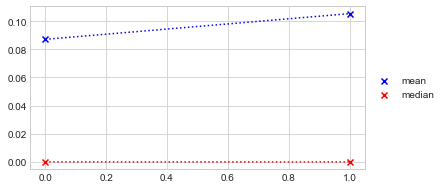

   rating      mean    median
0       0  0.087049  0.000075
1       1  0.105279  0.000070


In [96]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [97]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: 0.03610974162050345
Likert p: 0.5769526855783377

Binary rho: 0.03169969594376111
Binary p: 0.6558837239498998


## Headline sentiment absolute spaCy

In [98]:
# extract absolute sentiment values
likert_df["sentiment_title_abs_spacy"] = likert_df["sentiment_title_spacy"].abs()
binary_df["sentiment_title_abs_spacy"] = binary_df["sentiment_title_spacy"].abs()

signal = "sentiment_title_abs_spacy"

#### Scatterplots

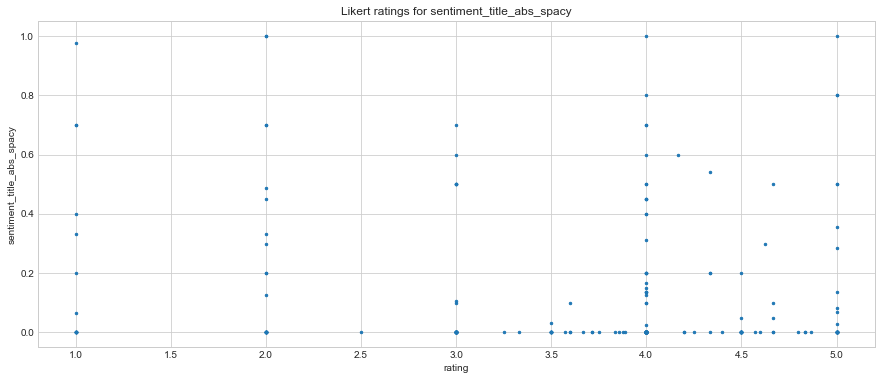

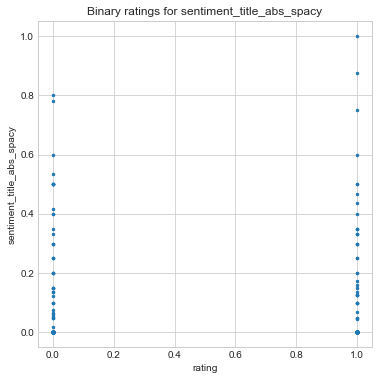

In [99]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

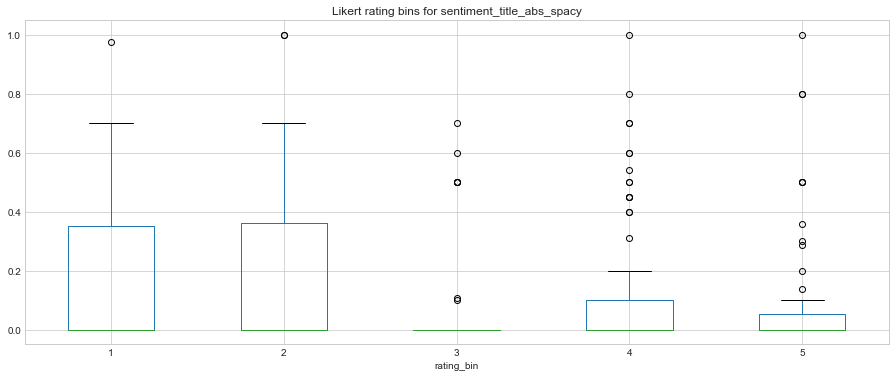

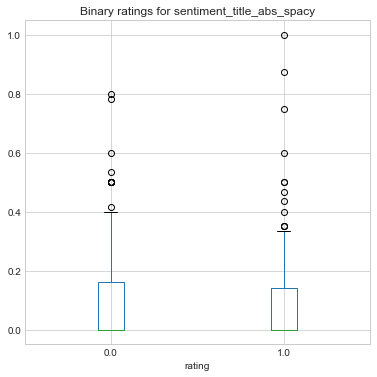

In [100]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

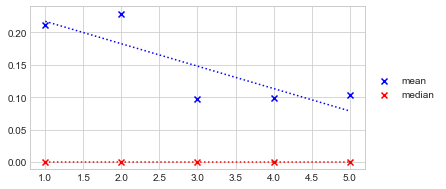

   rating      mean  median
0       1  0.210938     0.0
1       2  0.228993     0.0
2       3  0.097396     0.0
3       4  0.099204     0.0
4       5  0.102831     0.0


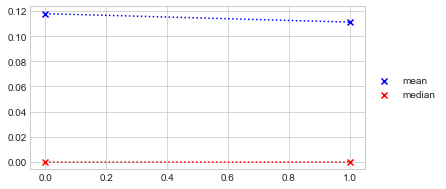

   rating      mean  median
0       0  0.117889     0.0
1       1  0.111142     0.0


In [101]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [102]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.029617814135785205
Likert p: 0.6473102757920859

Binary rho: -0.04416285098676175
Binary p: 0.5346355927687071


## Headline sentiment absolute VADER

In [103]:
# extract absolute sentiment values
likert_df["sentiment_title_abs_vader"] = likert_df["sentiment_title_vader"].abs()
binary_df["sentiment_title_abs_vader"] = binary_df["sentiment_title_vader"].abs()

signal = "sentiment_title_abs_vader"

#### Scatterplots

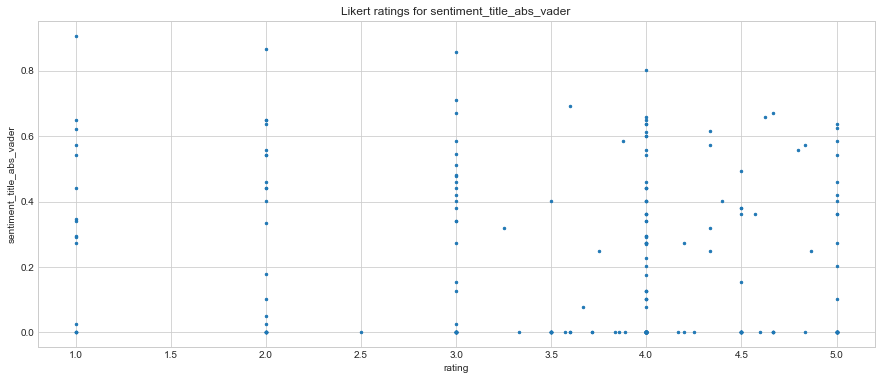

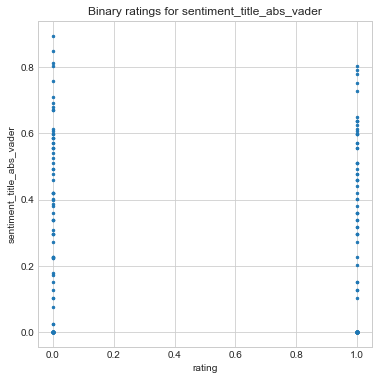

In [104]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

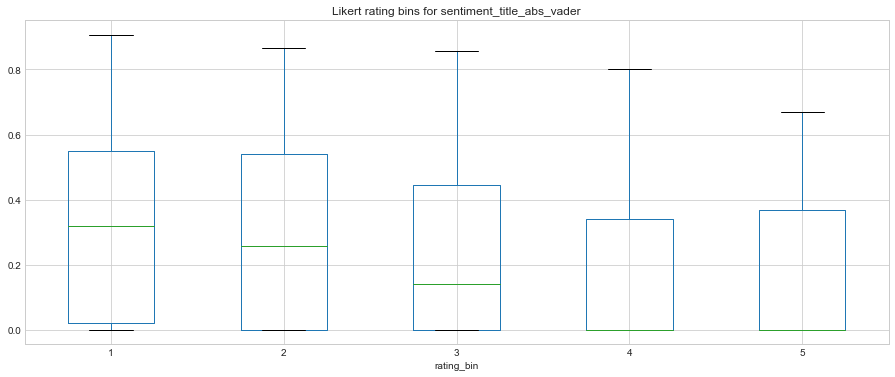

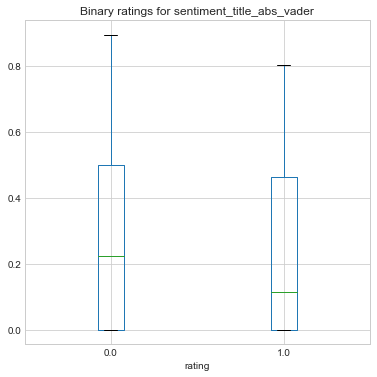

In [105]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

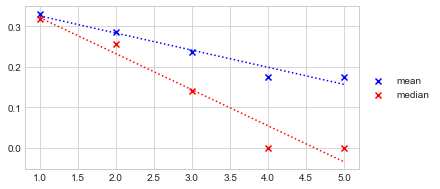

   rating      mean   median
0       1  0.331469  0.31800
1       2  0.286450  0.25660
2       3  0.236631  0.14055
3       4  0.175274  0.00000
4       5  0.175273  0.00000


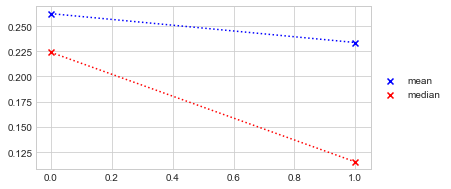

   rating      mean   median
0       0  0.262319  0.22395
1       1  0.233668  0.11535


In [106]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [107]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.13026959779932223
Likert p: 0.04333868027527041

Binary rho: -0.06385154622919001
Binary p: 0.369050037458426


## Headline sentiment FastText 1+5

In [108]:
# extract absolute sentiment values
likert_df["sentiment_title_fasttext1+5"] = (likert_df["sentiment_title_fasttext_1"] 
                                            + likert_df["sentiment_title_fasttext_5"])
binary_df["sentiment_title_fasttext1+5"] = (binary_df["sentiment_title_fasttext_1"] 
                                            + binary_df["sentiment_title_fasttext_5"])

signal = "sentiment_title_fasttext1+5"

#### Scatterplots

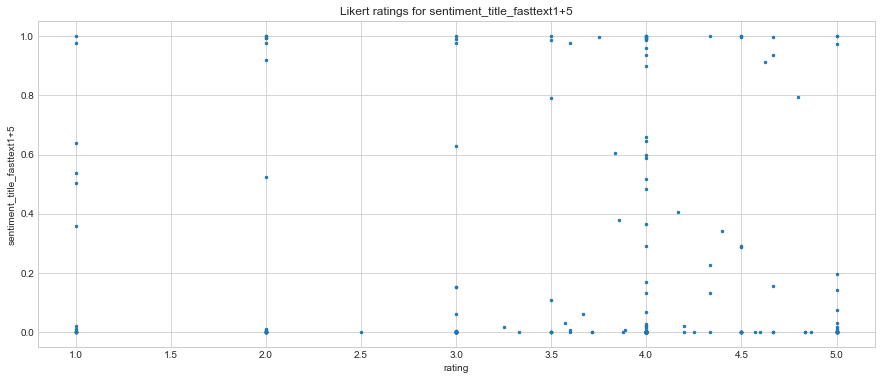

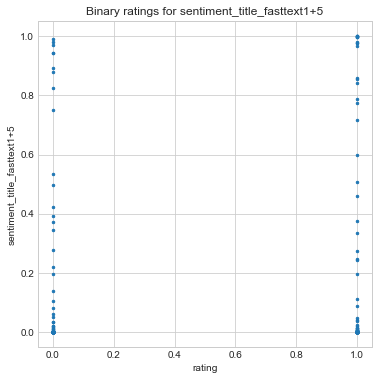

In [109]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

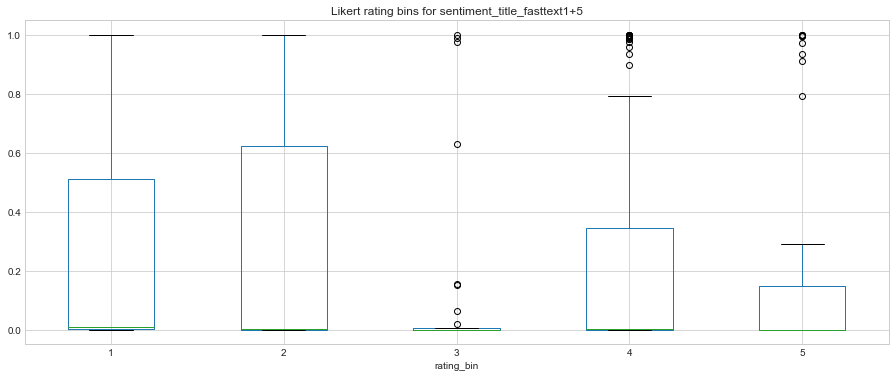

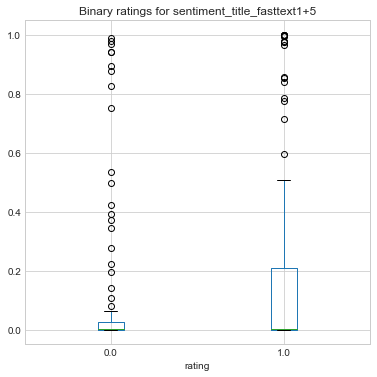

In [110]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

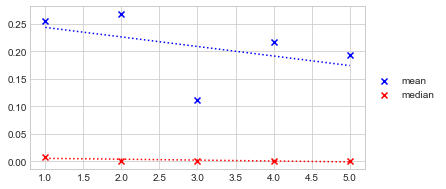

   rating      mean    median
0       1  0.253721  0.008474
1       2  0.267931  0.000368
2       3  0.110916  0.000027
3       4  0.215528  0.000974
4       5  0.193396  0.000079


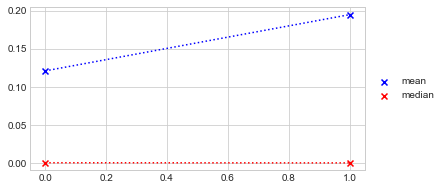

   rating      mean    median
0       0  0.121067  0.000899
1       1  0.194642  0.000679


In [111]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [112]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.008795264565831113
Likert p: 0.8919541219814793

Binary rho: 0.039405209975657635
Binary p: 0.5795815542911137


## Return original data

In [113]:
# get back original dataframes
likert_df = likert_copy
binary_df = binary_copy